In [1]:
import os
import cv2
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from tqdm import tqdm
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn import metrics
from sklearn.model_selection import KFold

# import要訓練的 model
from MRSKNet2c import MRSKNet

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_folder = "/home/cbel/Desktop/zhe/data"

In [2]:
def load_data(df, index, imgs_path, augment=False):
    imgs = {}
    labels = {}
    for i in range(len(imgs_path)):
        if augment:
            num = int(imgs_path[i][-11:-7])
        else:
            num = int(imgs_path[i][-8:-4])
        if num in index:
            if num not in imgs:
                imgs[num] = []
                labels[num] = int(df[df["nodule_number"]==num]["malignancy"])
            img = np.load(imgs_path[i])
            img = img / 255.0
            imgs[num].append(img)
    return imgs, labels

def generate_data(imgs, labels, index):
    train_imgs = []
    train_labels = []
    for key in index:
        for i in range(len(imgs[key])):
            train_imgs.append(imgs[key][i])
            train_labels.append(labels[key])
    train_imgs = np.array(train_imgs)
    train_labels = np.array(train_labels)
    train_labels = train_labels[:, np.newaxis]
    return train_imgs, train_labels

In [3]:
def train(train_loader, val_loader, model, lr, epochs):
    set_randomSeed()
    start = time.time()
#     if torch.cuda.device_count() > 1:
#         print("Let's use multiple GPUs!")
#         model = nn.DataParallel(model)

    model.to(device)
    print("parameter numbers:", sum(param.numel() for param in model.parameters()))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = nn.BCELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

    his_train_loss = []
    his_val_loss = []
    best_metrics = 0.0
    best_auc = 0.0
    best_acc = 0.0
    best_recall = 0.0
    
    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        preds_list = []
        labels_list = []

        train_loss = 0
        train_auc = 0
        train_acc = 0
        train_recall = 0
        train_specificity = 0
        train_precision = 0
        train_len = train_loader.__len__()

        val_loss = 0
        val_auc = 0
        val_acc = 0
        val_recall = 0
        val_specificity = 0
        val_precision = 0
        val_len = val_loader.__len__()

        model.train()
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            preds = model(inputs)
            batch_loss = loss(preds, labels)
            batch_loss.backward()
            optimizer.step()

            preds = preds.data.cpu().numpy()
            labels = labels.data.cpu().numpy()

            train_loss += batch_loss.item()
            if len(np.unique(labels)) == 2:
                train_auc += metrics.roc_auc_score(labels, preds)
            preds[preds > 0.5] = 1
            preds[preds != 1] = 0
            confusion = metrics.confusion_matrix(labels, preds)
            TP = confusion[1, 1]
            TN = confusion[0, 0]
            FP = confusion[0, 1]
            FN = confusion[1, 0]
            train_acc += ((TP + TN) / (TP + TN + FP + FN))
            train_recall += ((TP) / (TP + FN))
            train_specificity += ((TN) / (TN + FP))
            train_precision += ((TP) / (TP + FP))

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                preds = model(inputs)
                batch_loss = loss(preds, labels)

                preds = preds.data.cpu().numpy()
                labels = labels.data.cpu().numpy()
                preds_list.extend(preds.copy())
                labels_list.extend(labels.copy())

                val_loss += batch_loss.item()
                if len(np.unique(labels)) == 2:
                    val_auc += metrics.roc_auc_score(labels, preds)
                preds[preds > 0.5] = 1
                preds[preds != 1] = 0
                confusion = metrics.confusion_matrix(labels, preds)
                TP = confusion[1, 1]
                TN = confusion[0, 0]
                FP = confusion[0, 1]
                FN = confusion[1, 0]
                val_acc += ((TP + TN) / (TP + TN + FP + FN))
                val_recall += ((TP) / (TP + FN))
                val_specificity += ((TN) / (TN + FP))
                val_precision += ((TP) / (TP + FP))

        train_loss = train_loss / train_len
        train_auc = train_auc / train_len
        train_acc = train_acc / train_len
        train_recall = train_recall / train_len
        train_specificity = train_specificity / train_len
        train_precision = train_precision / train_len
        val_loss = val_loss / val_len
        val_auc = val_auc / val_len
        val_acc = val_acc / val_len
        val_recall = val_recall / val_len
        val_specificity = val_specificity / val_len
        val_precision = val_precision / val_len
        his_train_loss.append(train_loss)
        his_val_loss.append(val_loss)
        fpr, tpr, _ = metrics.roc_curve(labels_list, preds_list, drop_intermediate=False)

        scheduler.step()
        
        if val_auc + val_acc + val_recall >= best_metrics:
            roc = []
            roc.append(fpr)
            roc.append(tpr)
            roc.append(val_auc)
            best_metrics = val_auc + val_acc + val_recall
            best = [val_auc, val_acc, val_recall, val_specificity, val_precision, epoch+1]
            
    end = time.time()
    total_time = end - start
    print(f"Time : {int(total_time // 60)} m {int(total_time % 60)} s")
    print(f"BEST RESULT --> AUC:{best[0]:.4f}  ACC:{best[1]:.4f}  Recall:{best[2]:.4f}\
  Specificity:{best[3]:.4f} Precision:{best[4]:.4f}  Epoch:{best[5]}")
    return best, roc

In [4]:
import warnings
warnings.filterwarnings("ignore")

f = open(data_folder + "/other/textutr_performance.txt", "w")
datasets = ["ENT", "HOM", "GLN", "RLN", "RP", "SRE", "COA"]
all_datasets_roc = []

for dataset in datasets:
    print(dataset)
    all_metric = []
    df = pd.read_csv(data_folder + "/final_annotation.csv")
    df = df[df["malignancy"]!=2]
    index = df["nodule_number"].values

    imgs_path = glob(data_folder + f'/multi_view/{dataset}/*.npy')
    imgs_path.sort()
    imgs, labels = load_data(df, index, imgs_path)

    aug_path = glob(data_folder + f'/augment/{dataset}/*.npy')
    aug_path.sort()
    aug_imgs, aug_labels = load_data(df, index, aug_path, True)

    print(f"Input dimension: {imgs[1][0].shape}")

    with open(data_folder + "/tenFold.pickle", "rb") as f2:
        tenFold = pickle.load(f2)    

    all_roc = []
    for i in range(10):
        train_index = tenFold[i]["train"]
        val_index = tenFold[i]["val"]
        print(f"-----fold {i+1}-----")

        train_imgs, train_labels = generate_data(aug_imgs, aug_labels, train_index)
        val_imgs, val_labels = generate_data(imgs, labels, val_index)     

        unique, counts = np.unique(train_labels, return_counts=True)
        train_distribution = dict(zip(unique, counts))
        unique, counts = np.unique(val_labels, return_counts=True)
        val_distribution = dict(zip(unique, counts)) 

        print(f"Train distribution: {train_distribution}  Total number: {len(train_imgs)}")
        print(f"Val distribution:   {val_distribution}      Total number: {len(val_imgs)}")

        train_imgs = torch.FloatTensor(train_imgs)
        train_labels = torch.FloatTensor(train_labels)
        val_imgs = torch.FloatTensor(val_imgs)
        val_labels = torch.FloatTensor(val_labels)

        set_randomSeed()

        train_set = TensorDataset(train_imgs, train_labels)
        val_set = TensorDataset(val_imgs, val_labels)

        batch_size = 256
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        batch_size = 64
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

        fold_metric, roc = train(train_loader=train_loader, val_loader=val_loader, 
                            model=MRSKNet(), lr=1e-4, epochs=50)
        all_metric.append(fold_metric)
        all_roc.append(roc)
    all_datasets_roc.append(all_roc)
    final_metric = np.mean(all_metric, axis=0)
    print(f"FINAL RESULT --> AUC: {final_metric[0]:.4f}  ACC: {final_metric[1]:.4f}  Recall: {final_metric[2]:.4f}\
  Specificity: {final_metric[3]:.4f}  Precision: {final_metric[4]:.4f}")
    f.write(dataset + "\n")
    f.write(f"FINAL RESULT --> AUC: {final_metric[0]:.4f}  ACC: {final_metric[1]:.4f}  Recall: {final_metric[2]:.4f}\
  Specificity: {final_metric[3]:.4f}  Precision: {final_metric[4]:.4f}")
    f.write("\n")
f.close()

ENT
Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 3 m 0 s
BEST RESULT --> AUC:0.9311  ACC:0.8776  Recall:0.9143  Specificity:0.8481 Precision:0.8472  Epoch:11
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 8 s
BEST RESULT --> AUC:0.9682  ACC:0.9245  Recall:0.8777  Specificity:0.9697 Precision:0.9643  Epoch:10
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 58 s
BEST RESULT --> AUC:0.9734  ACC:0.9245  Recall:0.9286  Specificity:0.9343 Precision:0.9132  Epoch:11
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 58 s
BEST RESULT --> AUC:0.9834  ACC:0.9375  Recall:0.9091  Specificity:0.9677 Precision:0.9655  Epoch:4
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 58 s
BEST RESULT --> AUC:0.9761  ACC:0.9375  Recall:0.9032  Specificity:0.9697 Precision:0.9630  Epoch:16
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 58 s
BEST RESULT --> AUC:0.9539  ACC:0.9062  Recall:0.9107  Specificity:0.9028 Precision:0.8833  Epoch:3
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 58 s
BEST RESULT --> AUC:0.9512  ACC:0.9062  Recall:0.8750  Specificity:0.9375 Precision:0.9286  Epoch:42
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 59 s
BEST RESULT --> AUC:0.9662  ACC:0.9219  Recall:0.9265  Specificity:0.9167 Precision:0.9265  Epoch:34
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [05:17<00:00,  6.36s/it]


Time : 5 m 17 s
BEST RESULT --> AUC:0.9819  ACC:0.9453  Recall:0.9412  Specificity:0.9500 Precision:0.9545  Epoch:10
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


100%|██████████| 50/50 [06:40<00:00,  8.00s/it]


Time : 6 m 40 s
BEST RESULT --> AUC:0.9839  ACC:0.9609  Recall:0.9531  Specificity:0.9688 Precision:0.9677  Epoch:2
FINAL RESULT --> AUC: 0.9669  ACC: 0.9242  Recall: 0.9139  Specificity: 0.9365  Precision: 0.9314
HOM


  0%|          | 0/50 [00:00<?, ?it/s]

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 42 s
BEST RESULT --> AUC:0.9414  ACC:0.9141  Recall:0.9483  Specificity:0.8857 Precision:0.8824  Epoch:48
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 42 s
BEST RESULT --> AUC:0.9765  ACC:0.9453  Recall:0.9412  Specificity:0.9500 Precision:0.9545  Epoch:37
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 42 s
BEST RESULT --> AUC:0.9760  ACC:0.9271  Recall:0.9677  Specificity:0.8864 Precision:0.8963  Epoch:15
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 3 m 4 s
BEST RESULT --> AUC:0.9809  ACC:0.9401  Recall:0.9839  Specificity:0.8977 Precision:0.9027  Epoch:10
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9721  ACC:0.9323  Recall:0.9194  Specificity:0.9432 Precision:0.9430  Epoch:24
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9632  ACC:0.9375  Recall:0.9706  Specificity:0.9000 Precision:0.9211  Epoch:13
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9548  ACC:0.9167  Recall:0.9194  Specificity:0.9129 Precision:0.9098  Epoch:15
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


Time : 4 m 26 s
BEST RESULT --> AUC:0.9731  ACC:0.9314  Recall:0.9839  Specificity:0.8788 Precision:0.8901  Epoch:12
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


100%|██████████| 50/50 [07:04<00:00,  8.48s/it]


Time : 7 m 4 s
BEST RESULT --> AUC:0.9800  ACC:0.9609  Recall:0.9688  Specificity:0.9531 Precision:0.9545  Epoch:26
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


100%|██████████| 50/50 [07:04<00:00,  8.49s/it]


Time : 7 m 4 s
BEST RESULT --> AUC:0.9932  ACC:0.9609  Recall:0.9531  Specificity:0.9688 Precision:0.9677  Epoch:31
FINAL RESULT --> AUC: 0.9711  ACC: 0.9366  Recall: 0.9556  Specificity: 0.9177  Precision: 0.9222
GLN
Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


100%|██████████| 50/50 [07:04<00:00,  8.48s/it]


Time : 7 m 4 s
BEST RESULT --> AUC:0.9478  ACC:0.8776  Recall:0.9000  Specificity:0.8653 Precision:0.8562  Epoch:11
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88


  0%|          | 0/50 [00:00<?, ?it/s]

parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 6 m 25 s
BEST RESULT --> AUC:0.9692  ACC:0.9453  Recall:0.8939  Specificity:1.0000 Precision:1.0000  Epoch:44
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 55 s
BEST RESULT --> AUC:0.9724  ACC:0.9036  Recall:0.9286  Specificity:0.9030 Precision:0.8688  Epoch:11
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 56 s
BEST RESULT --> AUC:0.9711  ACC:0.9167  Recall:0.9099  Specificity:0.9242 Precision:0.9242  Epoch:10
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 57 s
BEST RESULT --> AUC:0.9692  ACC:0.9167  Recall:0.9032  Specificity:0.9280 Precision:0.9245  Epoch:24
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 49 s
BEST RESULT --> AUC:0.9409  ACC:0.9219  Recall:0.9483  Specificity:0.9000 Precision:0.8939  Epoch:48
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 48 s
BEST RESULT --> AUC:0.9585  ACC:0.8828  Recall:0.8636  Specificity:0.9032 Precision:0.9000  Epoch:45
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 48 s
BEST RESULT --> AUC:0.9647  ACC:0.9236  Recall:0.9559  Specificity:0.8976 Precision:0.8929  Epoch:15
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 4 m 49 s
BEST RESULT --> AUC:0.9863  ACC:0.9096  Recall:0.9500  Specificity:0.8559 Precision:0.8833  Epoch:27
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [03:59<00:00,  4.80s/it]


Time : 3 m 59 s
BEST RESULT --> AUC:0.9946  ACC:0.9609  Recall:0.9559  Specificity:0.9667 Precision:0.9697  Epoch:15
FINAL RESULT --> AUC: 0.9675  ACC: 0.9159  Recall: 0.9209  Specificity: 0.9144  Precision: 0.9114
RLN


  0%|          | 0/50 [00:00<?, ?it/s]

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9507  ACC:0.8932  Recall:0.9375  Specificity:0.8522 Precision:0.8583  Epoch:26
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9683  ACC:0.9609  Recall:0.9375  Specificity:0.9844 Precision:0.9828  Epoch:27
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9770  ACC:0.9453  Recall:0.9355  Specificity:0.9545 Precision:0.9500  Epoch:18
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9849  ACC:0.9531  Recall:0.9688  Specificity:0.9375 Precision:0.9412  Epoch:23
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9706  ACC:0.9401  Recall:0.9516  Specificity:0.9280 Precision:0.9282  Epoch:10
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9496  ACC:0.9089  Recall:0.9655  Specificity:0.8500 Precision:0.8637  Epoch:48
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9467  ACC:0.9062  Recall:0.9091  Specificity:0.9032 Precision:0.9091  Epoch:45
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 55 s
BEST RESULT --> AUC:0.9635  ACC:0.9236  Recall:0.9677  Specificity:0.8788 Precision:0.8880  Epoch:12
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9868  ACC:0.9236  Recall:0.9833  Specificity:0.8618 Precision:0.8786  Epoch:24
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


Time : 2 m 53 s
BEST RESULT --> AUC:0.9931  ACC:0.9688  Recall:0.9412  Specificity:1.0000 Precision:1.0000  Epoch:10
FINAL RESULT --> AUC: 0.9691  ACC: 0.9324  Recall: 0.9498  Specificity: 0.9150  Precision: 0.9200
RP


  0%|          | 0/50 [00:00<?, ?it/s]

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9385  ACC:0.8854  Recall:0.9286  Specificity:0.8481 Precision:0.8498  Epoch:11
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9692  ACC:0.9453  Recall:0.9032  Specificity:0.9848 Precision:0.9808  Epoch:24
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 52 s
BEST RESULT --> AUC:0.9741  ACC:0.9245  Recall:0.9194  Specificity:0.9280 Precision:0.9258  Epoch:15
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9824  ACC:0.9531  Recall:0.9677  Specificity:0.9394 Precision:0.9394  Epoch:15
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9795  ACC:0.9453  Recall:0.9194  Specificity:0.9697 Precision:0.9643  Epoch:16
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9385  ACC:0.9141  Recall:0.9531  Specificity:0.8750 Precision:0.8919  Epoch:40
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9449  ACC:0.8880  Recall:0.8576  Specificity:0.8970 Precision:0.9062  Epoch:25
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9588  ACC:0.9158  Recall:0.9559  Specificity:0.8810 Precision:0.8806  Epoch:34
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9838  ACC:0.9297  Recall:0.9559  Specificity:0.9000 Precision:0.9189  Epoch:16
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [02:53<00:00,  3.46s/it]


Time : 2 m 53 s
BEST RESULT --> AUC:0.9916  ACC:0.9531  Recall:0.9444  Specificity:0.9643 Precision:0.9706  Epoch:6
FINAL RESULT --> AUC: 0.9661  ACC: 0.9254  Recall: 0.9305  Specificity: 0.9187  Precision: 0.9228
SRE


  0%|          | 0/50 [00:00<?, ?it/s]

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9429  ACC:0.9010  Recall:0.9429  Specificity:0.8653 Precision:0.8634  Epoch:11
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 52 s
BEST RESULT --> AUC:0.9614  ACC:0.9375  Recall:0.9032  Specificity:0.9697 Precision:0.9630  Epoch:24
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9804  ACC:0.9453  Recall:0.9833  Specificity:0.9118 Precision:0.9143  Epoch:21
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9868  ACC:0.9297  Recall:1.0000  Specificity:0.8676 Precision:0.8846  Epoch:21
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9644  ACC:0.9453  Recall:0.9219  Specificity:0.9688 Precision:0.9655  Epoch:27
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9599  ACC:0.9375  Recall:0.9516  Specificity:0.9242 Precision:0.9242  Epoch:12
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9508  ACC:0.8854  Recall:0.9143  Specificity:0.8653 Precision:0.8587  Epoch:11
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9736  ACC:0.9531  Recall:0.9677  Specificity:0.9394 Precision:0.9394  Epoch:22
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9878  ACC:0.9609  Recall:0.9697  Specificity:0.9516 Precision:0.9559  Epoch:38
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


Time : 2 m 53 s
BEST RESULT --> AUC:0.9886  ACC:0.9531  Recall:0.9306  Specificity:0.9821 Precision:0.9844  Epoch:6
FINAL RESULT --> AUC: 0.9696  ACC: 0.9349  Recall: 0.9485  Specificity: 0.9246  Precision: 0.9253
COA


  0%|          | 0/50 [00:00<?, ?it/s]

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9498  ACC:0.8854  Recall:0.9286  Specificity:0.8481 Precision:0.8498  Epoch:11
-----fold 2-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9609  ACC:0.9453  Recall:0.9194  Specificity:0.9697 Precision:0.9643  Epoch:10
-----fold 3-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9726  ACC:0.9531  Recall:0.9194  Specificity:0.9848 Precision:0.9815  Epoch:38
-----fold 4-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9824  ACC:0.9375  Recall:0.9500  Specificity:0.9265 Precision:0.9219  Epoch:5
-----fold 5-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9756  ACC:0.9531  Recall:0.9194  Specificity:0.9848 Precision:0.9815  Epoch:24
-----fold 6-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 54 s
BEST RESULT --> AUC:0.9495  ACC:0.9010  Recall:0.9265  Specificity:0.8833 Precision:0.8765  Epoch:13
-----fold 7-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9632  ACC:0.8880  Recall:0.8777  Specificity:0.8977 Precision:0.8917  Epoch:10
-----fold 8-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9657  ACC:0.9375  Recall:0.9412  Specificity:0.9333 Precision:0.9412  Epoch:15
-----fold 9-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


  0%|          | 0/50 [00:00<?, ?it/s]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9848  ACC:0.9609  Recall:0.9848  Specificity:0.9355 Precision:0.9444  Epoch:47
-----fold 10-----
Train distribution: {0: 6448, 1: 6192}  Total number: 12640
Val distribution:   {0: 44, 1: 43}      Total number: 87
parameter numbers: 114265


100%|██████████| 50/50 [02:53<00:00,  3.48s/it]

Time : 2 m 53 s
BEST RESULT --> AUC:0.9878  ACC:0.9609  Recall:0.9531  Specificity:0.9688 Precision:0.9677  Epoch:2
FINAL RESULT --> AUC: 0.9692  ACC: 0.9323  Recall: 0.9320  Specificity: 0.9333  Precision: 0.9320


In [5]:
def get_mean_roc(rocc):
    roc = rocc.copy()
    max_len = 0
    for r in roc:
        if len(r[0]) > max_len:
            max_len = len(r[0])
    for i in range(10):
        if len(roc[i][0]) != max_len:
            roc[i][0] = np.insert(roc[i][0], max_len//2, (roc[i][0][(max_len//2)-1]+roc[i][0][max_len//2])/2)
            roc[i][1] = np.insert(roc[i][1], max_len//2, (roc[i][1][(max_len//2)-1]+roc[i][1][max_len//2])/2)
    return np.mean(roc, axis=0)

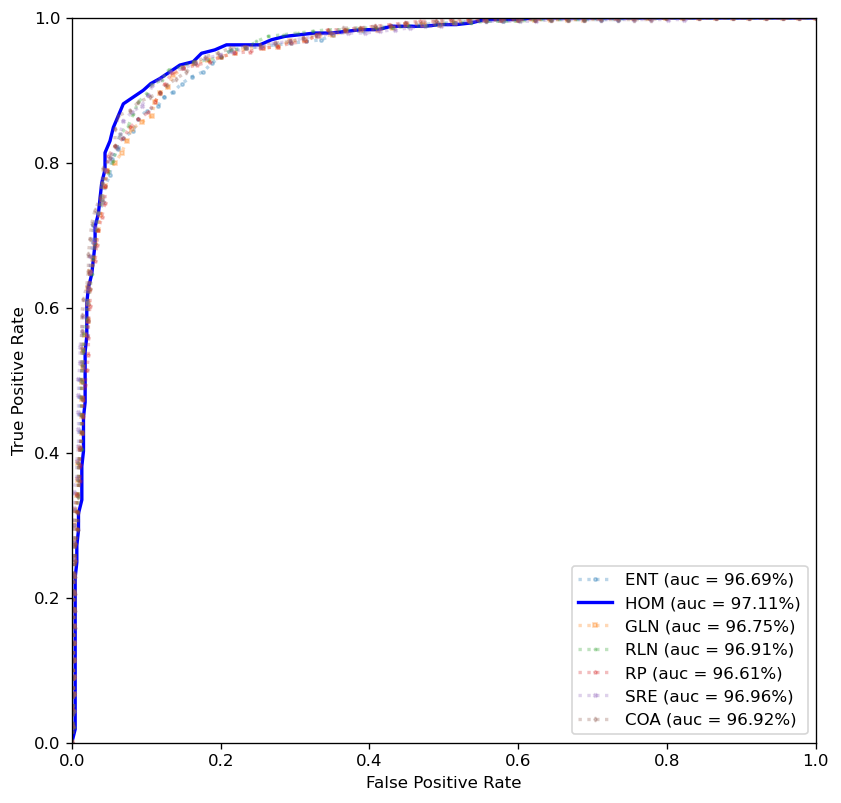

In [6]:
markers = ["o", "^", "s", "*", "p", "X", "d", "_"]
# linestyle="dotted", marker=markers[i],
plt.figure(figsize=(8, 8), dpi=120)
lw = 2
for i in range(7):
    if i == 1:
        mroc = get_mean_roc(all_datasets_roc[i])
        plt.plot(mroc[0], mroc[1], color="blue", lw=lw,
                 label=f'{datasets[i]} (auc = {mroc[2]*100:.2f}%)')
    else:    
        mroc = get_mean_roc(all_datasets_roc[i])
        plt.plot(mroc[0], mroc[1], alpha=0.3, lw=lw, linestyle="dotted", marker=markers[i], markersize=2,
                 label=f'{datasets[i]} (auc = {mroc[2]*100:.2f}%)')
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(data_folder + "/other/auc_texture.tiff")
plt.show()